In [2]:
import os 
import random
import numpy as np

import torch 
from torch import nn
from torch.nn.utils import weight_norm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2
import json

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model_ident = "tcn"
unique_iden = "epoch100_emb128"

main_dir = "D:\\FYP\\HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"data","sequence_data","random_50f")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
embeddings_save = os.path.join(main_dir,"embedding_save")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)
os.makedirs(models_saves,exist_ok=True)
os.makedirs(embeddings_save,exist_ok=True)

In [5]:
config = {
    "n_epochs":100,
    "model":{
        "seq_len":50,
        "num_features":32,
        "num_channels":[20,120,20,4],
        "kernel_size":3,
        "dropout":0.3,
        "dev":device
    }
}

In [6]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [9]:
 class_names = os.listdir(os.path.join(main_dir,"data","skel_out","hmbd51"))

In [10]:
id2clsname, clsname2id = classname_id(class_names)

In [11]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [12]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6746, 1446, 1445)

In [13]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [14]:
len(train_file_list),len(val_file_list),len(test_file_list)

(6720, 1440, 1440)

In [15]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28],file_name=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split("/")[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]
        
        shape = coords.shape
        
        coords = torch.from_numpy(coords).float()
        
        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)
        
        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        if self.file_name:
            return coords, label, self.class2id[action_type],a_file["video_size"],self.file_list[idx]
        return coords, label, self.class2id[action_type],a_file["video_size"]

In [16]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [17]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [18]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class TCNEnc(nn.Module):
    def __init__(self, seq_len=50,num_features=36, num_channels=[20,20,20,4], embedding_size=128, kernel_size=3, dropout=0.3):
        super(TCNEnc, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels = num_channels
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout

        self.tcn = TemporalConvNet(self.seq_len, num_channels=self.num_channels, kernel_size = self.kernel_size, dropout=self.dropout)
        self.linear = nn.Linear(self.num_channels[-1]*self.num_features, self.embedding_size)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x)
        output = torch.flatten(output,start_dim=1)
        output = self.linear(output)
        return output

class TCNDec(nn.Module):
    def __init__(self, seq_len=50,num_features=36, num_channels=[20,20,20], embedding_size=128, kernel_size=3, dropout=0.3,encoder_tcn_out=4):
        super(TCNDec, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels = num_channels
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.encoder_tcn_out =  encoder_tcn_out

        self.num_channels.append(seq_len)

        self.linear = nn.Linear(self.embedding_size,self.encoder_tcn_out*self.num_features)
        self.tcn = TemporalConvNet(self.encoder_tcn_out, num_channels=self.num_channels, kernel_size = self.kernel_size, dropout=self.dropout)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.linear(x)
        output = output.view(-1,self.encoder_tcn_out,self.num_features)
        output = self.tcn(output)
        return output

    
class TCNEncoderDecoder(nn.Module):
    def __init__(self, seq_len=50,num_features=36, num_channels=[20,20,20,4], embedding_size=128, kernel_size=3, dropout=0.3):
        super(TCNEncoderDecoder, self).__init__()
        self.seq_len = seq_len
        self.num_features = num_features
        self.num_channels_encoder = num_channels
        self.num_channels_decoder = num_channels[::-1][1:]
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.dropout = dropout   

        self.encoder = TCNEnc(
            seq_len = self.seq_len,
            num_features = self.num_features,
            num_channels = self.num_channels_encoder,
            embedding_size = self.embedding_size,
            kernel_size = self.kernel_size,
            dropout = self.dropout)

        self.decoder = TCNDec(
            seq_len = self.seq_len,
            encoder_tcn_out= self.num_channels_encoder[-1],
            num_features = self.num_features,
            num_channels = self.num_channels_decoder,
            embedding_size = self.embedding_size,
            kernel_size = self.kernel_size,
            dropout = self.dropout)

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output, embedding

In [11]:
tcn_encoder = TCNEnc()
tcn_decoder = TCNDec()

tcn_model = TCNEncoderDecoder(
    seq_len=config["model"]["seq_len"],
    num_features=config["model"]["num_features"],
    num_channels=config["model"]["num_channels"],
    embedding_size=config["model"]["embedding_size"],
    kernel_size=config["model"]["kernel_size"],
    dropout=config["model"]["dropout"]
)


In [12]:
rand_sample = torch.randn((32,60,32))

In [8]:
rand_sample.shape 

torch.Size([32, 50, 36])

In [278]:
out = tcn_encoder(rand_sample)

In [279]:
out.shape

torch.Size([32, 128])

In [280]:
out = tcn_decoder(out)

In [281]:
tcn_model(out)[0].shape

torch.Size([32, 50, 36])

In [282]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles 
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines 
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_skeletons(frame1 , frame2, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles for the frame-set-1
    for coord in frame1:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add circles for the frame-set-2
    for coord in frame2:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(0, 255, 0), thickness=6)

    # add lines 
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line

        st = frame1[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame1[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(250, 0, 0), thickness=3)

        st = frame2[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))
        en = frame2[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))
        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 250, 0), thickness=3)

    return img_3

def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten 
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file, 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_cmp_video(points1, points2, save_file, frame_h, frame_w):
    # make 3D if points are flatten 
    if len(points1.shape) == 2:
        fts = points1.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points1 = np.transpose(np.array([points1[:, x_cds], points1[:, y_cds], points1[:, z_cds]]), (1,2,0))

    if len(points2.shape) == 2:
        fts = points2.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points2 = np.transpose(np.array([points2[:, x_cds], points2[:, y_cds], points2[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file, 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame_1 in enumerate(points1):
        frame_2 = points2[__id]
        skel_image = gen_skeletons(frame_1, frame_2, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,model_name=model_ident,unique_name=unique_iden):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1))

    os.makedirs(f"{epoch_vids}/{model_name}/{unique_name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{model_name}/{unique_name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save(model.state_dict(), f"{PATH}/{unique_name}.pt")

In [283]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    #contrastive_loss = SupConLoss(contrast_mode="one").to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_random_video(model,val_data,epoch,batch_size,model_name=model_ident,unique_name=unique_iden)

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    save_model(model,model_ident,unique_iden)
    return model.eval(), history

In [284]:
model, history = train_model(
  tcn_model, 
  train_dl, 
  val_dl, 
  n_epochs=150
)

100%|██████████| 210/210 [00:23<00:00,  8.84it/s]


Epoch 1: train loss 0.2044208838826134 val loss 0.1436031214065022


100%|██████████| 210/210 [00:31<00:00,  6.75it/s]


Epoch 2: train loss 0.12463835474281083 val loss 0.11575356837775973


100%|██████████| 210/210 [04:42<00:00,  1.34s/it]  


Epoch 3: train loss 0.1138811812159561 val loss 0.10887348651885986


100%|██████████| 210/210 [14:04<00:00,  4.02s/it]   


Epoch 4: train loss 0.10848717540502548 val loss 0.10373047805494733


100%|██████████| 210/210 [00:23<00:00,  9.02it/s]


Epoch 5: train loss 0.10516040428053765 val loss 0.10247811691628562


100%|██████████| 210/210 [00:22<00:00,  9.17it/s]


Epoch 6: train loss 0.10412160441988991 val loss 0.10119936317205429


100%|██████████| 210/210 [00:22<00:00,  9.18it/s]


Epoch 7: train loss 0.10288854773555484 val loss 0.09969732181893455


100%|██████████| 210/210 [00:22<00:00,  9.16it/s]


Epoch 8: train loss 0.10219088682816142 val loss 0.09918101777633032


100%|██████████| 210/210 [00:23<00:00,  8.88it/s]


Epoch 9: train loss 0.10150712813649859 val loss 0.09876426541142994


100%|██████████| 210/210 [00:22<00:00,  9.20it/s]


Epoch 10: train loss 0.10145682085837637 val loss 0.09859470228354136


100%|██████████| 210/210 [00:23<00:00,  9.04it/s]


Epoch 11: train loss 0.10089581544910159 val loss 0.09844077544079886


100%|██████████| 210/210 [00:23<00:00,  9.00it/s]


Epoch 12: train loss 0.10060480119926589 val loss 0.09821038792530695


100%|██████████| 210/210 [00:21<00:00,  9.74it/s]


Epoch 13: train loss 0.10058013097870917 val loss 0.09812609238757028


100%|██████████| 210/210 [00:22<00:00,  9.23it/s]


Epoch 14: train loss 0.10048031661482085 val loss 0.0980061325762007


100%|██████████| 210/210 [00:22<00:00,  9.48it/s]


Epoch 15: train loss 0.10034647679754666 val loss 0.09809351232316758


100%|██████████| 210/210 [00:22<00:00,  9.17it/s]


Epoch 16: train loss 0.10027154297346161 val loss 0.09781764249006906


100%|██████████| 210/210 [00:22<00:00,  9.19it/s]


Epoch 17: train loss 0.10022944435477257 val loss 0.09788738638162613


100%|██████████| 210/210 [00:23<00:00,  8.98it/s]


Epoch 18: train loss 0.10011593255968321 val loss 0.09779960960149765


100%|██████████| 210/210 [00:25<00:00,  8.31it/s]


Epoch 19: train loss 0.10006113375226657 val loss 0.09778665370411344


100%|██████████| 210/210 [00:22<00:00,  9.24it/s]


Epoch 20: train loss 0.10007001395736422 val loss 0.09798236638307571


100%|██████████| 210/210 [00:22<00:00,  9.29it/s]


Epoch 21: train loss 0.10012847252544903 val loss 0.09772196263074875


100%|██████████| 210/210 [00:23<00:00,  9.04it/s]


Epoch 22: train loss 0.09988874824983733 val loss 0.09776452349291907


100%|██████████| 210/210 [00:22<00:00,  9.15it/s]


Epoch 23: train loss 0.10000155639080774 val loss 0.09777435130543179


100%|██████████| 210/210 [00:22<00:00,  9.20it/s]


Epoch 24: train loss 0.09990064384681838 val loss 0.09788230939043893


100%|██████████| 210/210 [00:23<00:00,  9.12it/s]


Epoch 25: train loss 0.09993354862644559 val loss 0.09744645489586724


100%|██████████| 210/210 [00:23<00:00,  9.12it/s]


Epoch 26: train loss 0.09977754648952257 val loss 0.09749159382449256


100%|██████████| 210/210 [00:22<00:00,  9.15it/s]


Epoch 27: train loss 0.09988067689396087 val loss 0.09752089513672722


100%|██████████| 210/210 [00:22<00:00,  9.18it/s]


Epoch 28: train loss 0.09984541340243248 val loss 0.09745797961950302


100%|██████████| 210/210 [00:22<00:00,  9.20it/s]


Epoch 29: train loss 0.09979537682873862 val loss 0.09777675138579475


100%|██████████| 210/210 [00:22<00:00,  9.15it/s]


Epoch 30: train loss 0.0998210704042798 val loss 0.0974044597811169


100%|██████████| 210/210 [00:23<00:00,  9.12it/s]


Epoch 31: train loss 0.09974529384857132 val loss 0.09743756883674198


100%|██████████| 210/210 [00:22<00:00,  9.15it/s]


Epoch 32: train loss 0.09976906322297596 val loss 0.09757911778158612


100%|██████████| 210/210 [00:23<00:00,  9.04it/s]


Epoch 33: train loss 0.10013402874271075 val loss 0.09735788189702564


100%|██████████| 210/210 [00:22<00:00,  9.18it/s]


Epoch 34: train loss 0.09966114780732564 val loss 0.0973700612783432


100%|██████████| 210/210 [00:22<00:00,  9.25it/s]


Epoch 35: train loss 0.09965106688794635 val loss 0.09718371530373891


100%|██████████| 210/210 [00:22<00:00,  9.23it/s]


Epoch 36: train loss 0.09967106438818432 val loss 0.09748535719182756


100%|██████████| 210/210 [00:22<00:00,  9.17it/s]


Epoch 37: train loss 0.10005787760019302 val loss 0.09728821814060211


100%|██████████| 210/210 [00:23<00:00,  9.13it/s]


Epoch 38: train loss 0.09954975513475282 val loss 0.09726443141698837


100%|██████████| 210/210 [00:22<00:00,  9.25it/s]


Epoch 39: train loss 0.09966484503377052 val loss 0.09724891997045941


100%|██████████| 210/210 [00:23<00:00,  9.08it/s]


Epoch 40: train loss 0.09958866220854577 val loss 0.09724923256370756


100%|██████████| 210/210 [00:22<00:00,  9.24it/s]


Epoch 41: train loss 0.09989425600284622 val loss 0.0971740432911449


100%|██████████| 210/210 [00:23<00:00,  9.07it/s]


Epoch 42: train loss 0.09947261469704764 val loss 0.09723514351579877


100%|██████████| 210/210 [00:23<00:00,  9.13it/s]


Epoch 43: train loss 0.09949595960123199 val loss 0.09728611326879925


100%|██████████| 210/210 [00:23<00:00,  8.97it/s]


Epoch 44: train loss 0.09956773842374483 val loss 0.0972123083141115


100%|██████████| 210/210 [00:24<00:00,  8.41it/s]


Epoch 45: train loss 0.09948864249246461 val loss 0.09709890368911955


100%|██████████| 210/210 [00:20<00:00, 10.00it/s]


Epoch 46: train loss 0.0995422211076532 val loss 0.09720383849408891


100%|██████████| 210/210 [00:21<00:00, 10.00it/s]


Epoch 47: train loss 0.09966563060879707 val loss 0.09716500358449089


100%|██████████| 210/210 [00:20<00:00, 10.04it/s]


Epoch 48: train loss 0.09945206681177729 val loss 0.09696400612592697


100%|██████████| 210/210 [00:21<00:00,  9.63it/s]


Epoch 49: train loss 0.0994380173938615 val loss 0.09723281512657801


100%|██████████| 210/210 [00:21<00:00,  9.78it/s]


Epoch 50: train loss 0.09955679543671153 val loss 0.09706266323725382


100%|██████████| 210/210 [00:24<00:00,  8.64it/s]


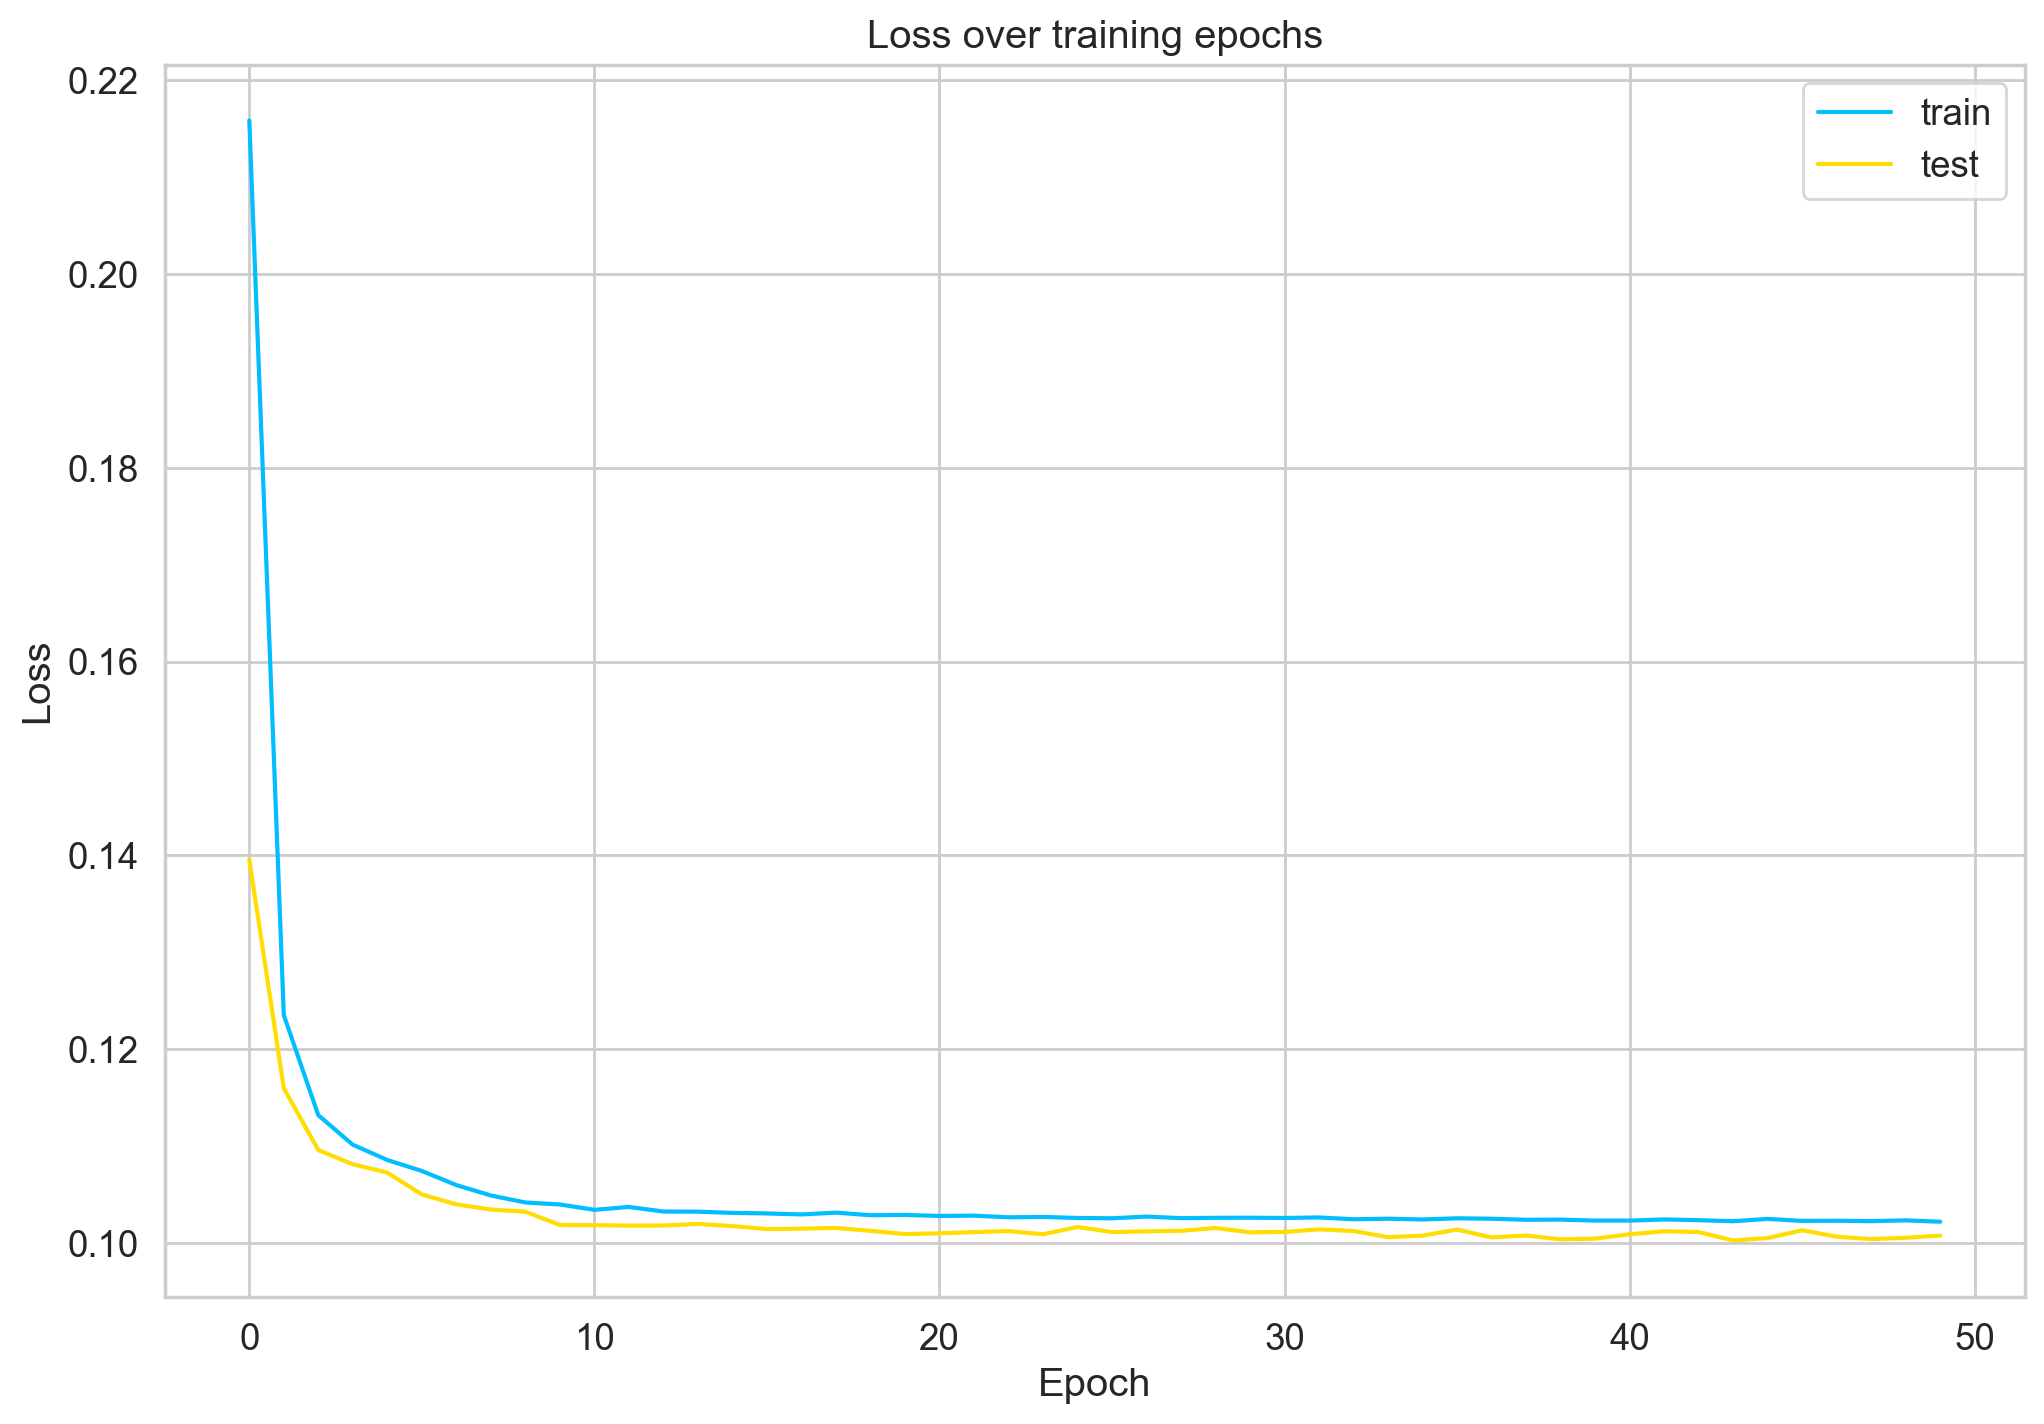

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
def get_embedding_list(model,test_set,model_identifier=model_ident,unique_iden=unique_iden, save_file=True):
    embedding_list = {}
    output_list = {}
    with torch.no_grad():
        for in_seq,tar_seq,action,vid_size in tqdm(test_set):
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,embedding  = model(in_seq)

            for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                    try:
                        if len(embedding_list[int(action)])<=50:
                            embedding_list[int(action)].append(emb)
                            output_list[int(action)].append(seq)
                    except KeyError:
                        embedding_list[int(action)] = [emb]
                        output_list[int(action)] = [emb]

    if save_file:  
        os.makedirs(f"{embeddings_save}/{model_identifier}/{unique_iden}",exist_ok=True)
        with open(f"{embeddings_save}/{model_identifier}/{unique_iden}/embedding_list.pkl","wb") as f0:
            pickle.dump(embedding_list,f0)

        with open(f"{embeddings_save}/{model_identifier}/{unique_iden}/outputs_list.pkl","wb") as f0:
            pickle.dump(output_list,f0)


    return embedding_list,output_list
        


    
            
        
        #embedding_list[]

In [ ]:
emb_list,out_list = get_embedding_list(model,test_dl,model_ident,"epoch50_randsample_input")

100%|██████████| 45/45 [00:02<00:00, 15.46it/s]


In [ ]:
def draw_heatmaps(arr_list,nrows=5,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

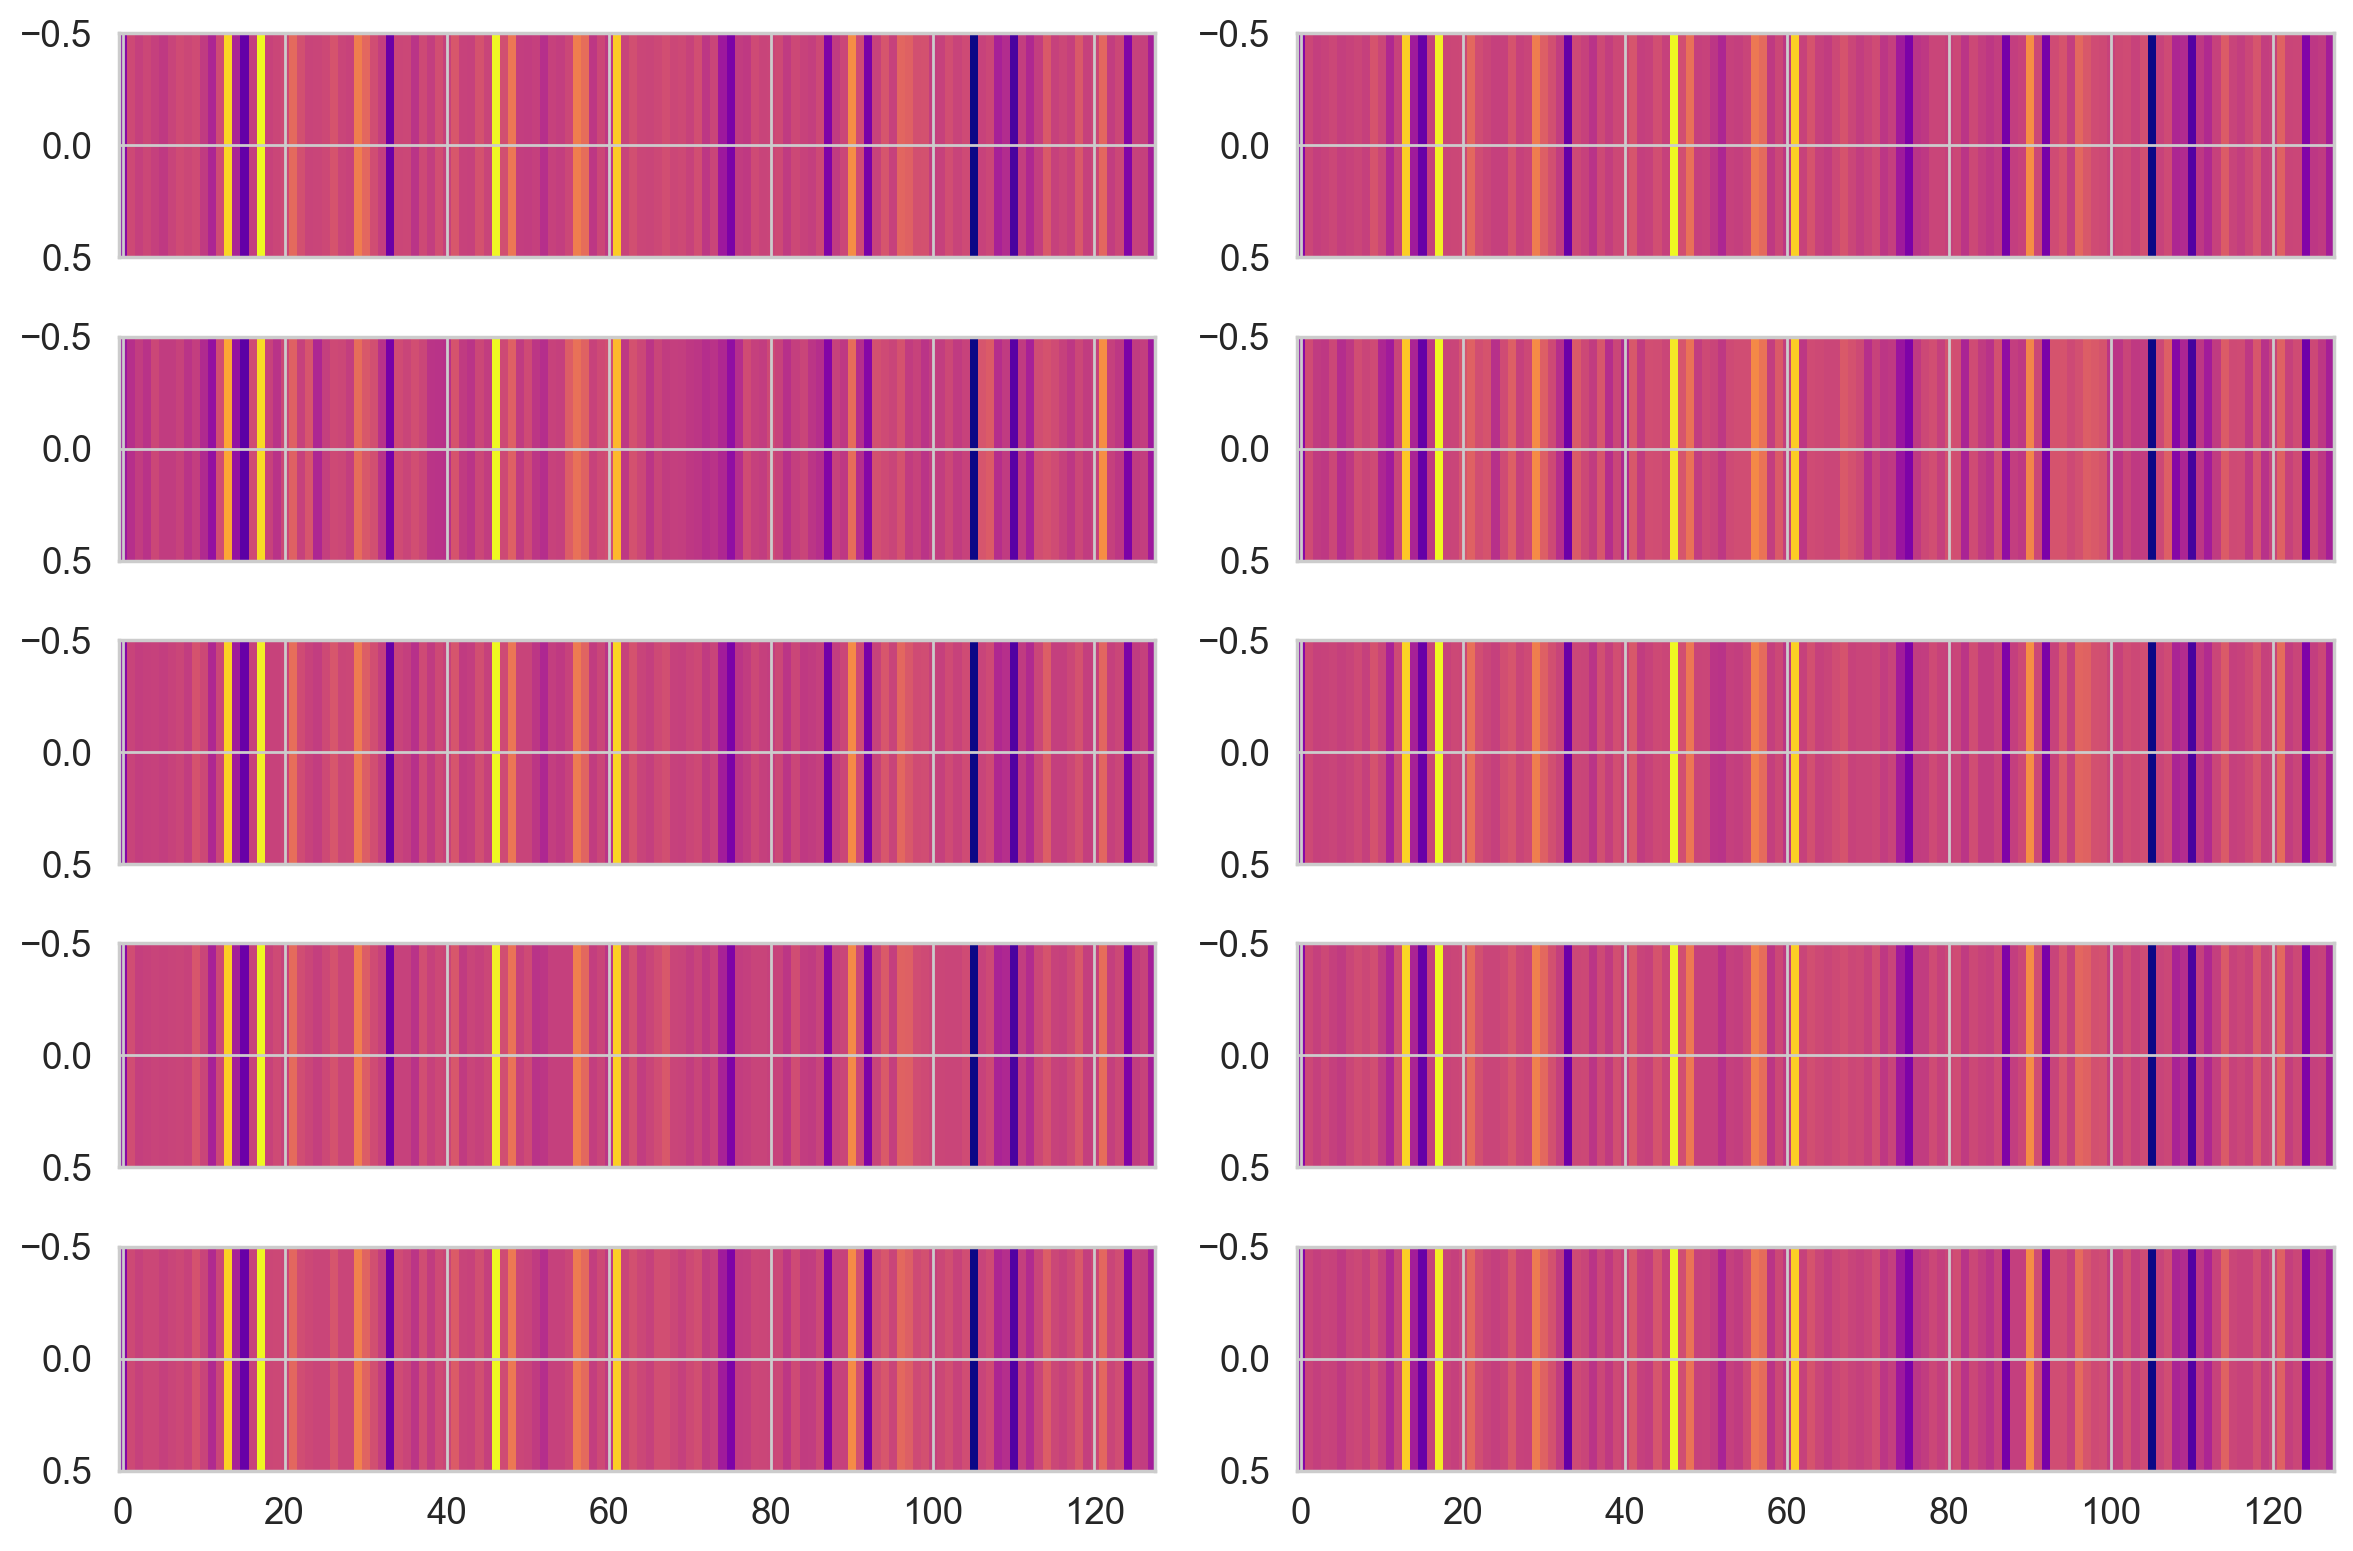

In [ ]:
draw_heatmaps(emb_list[19])

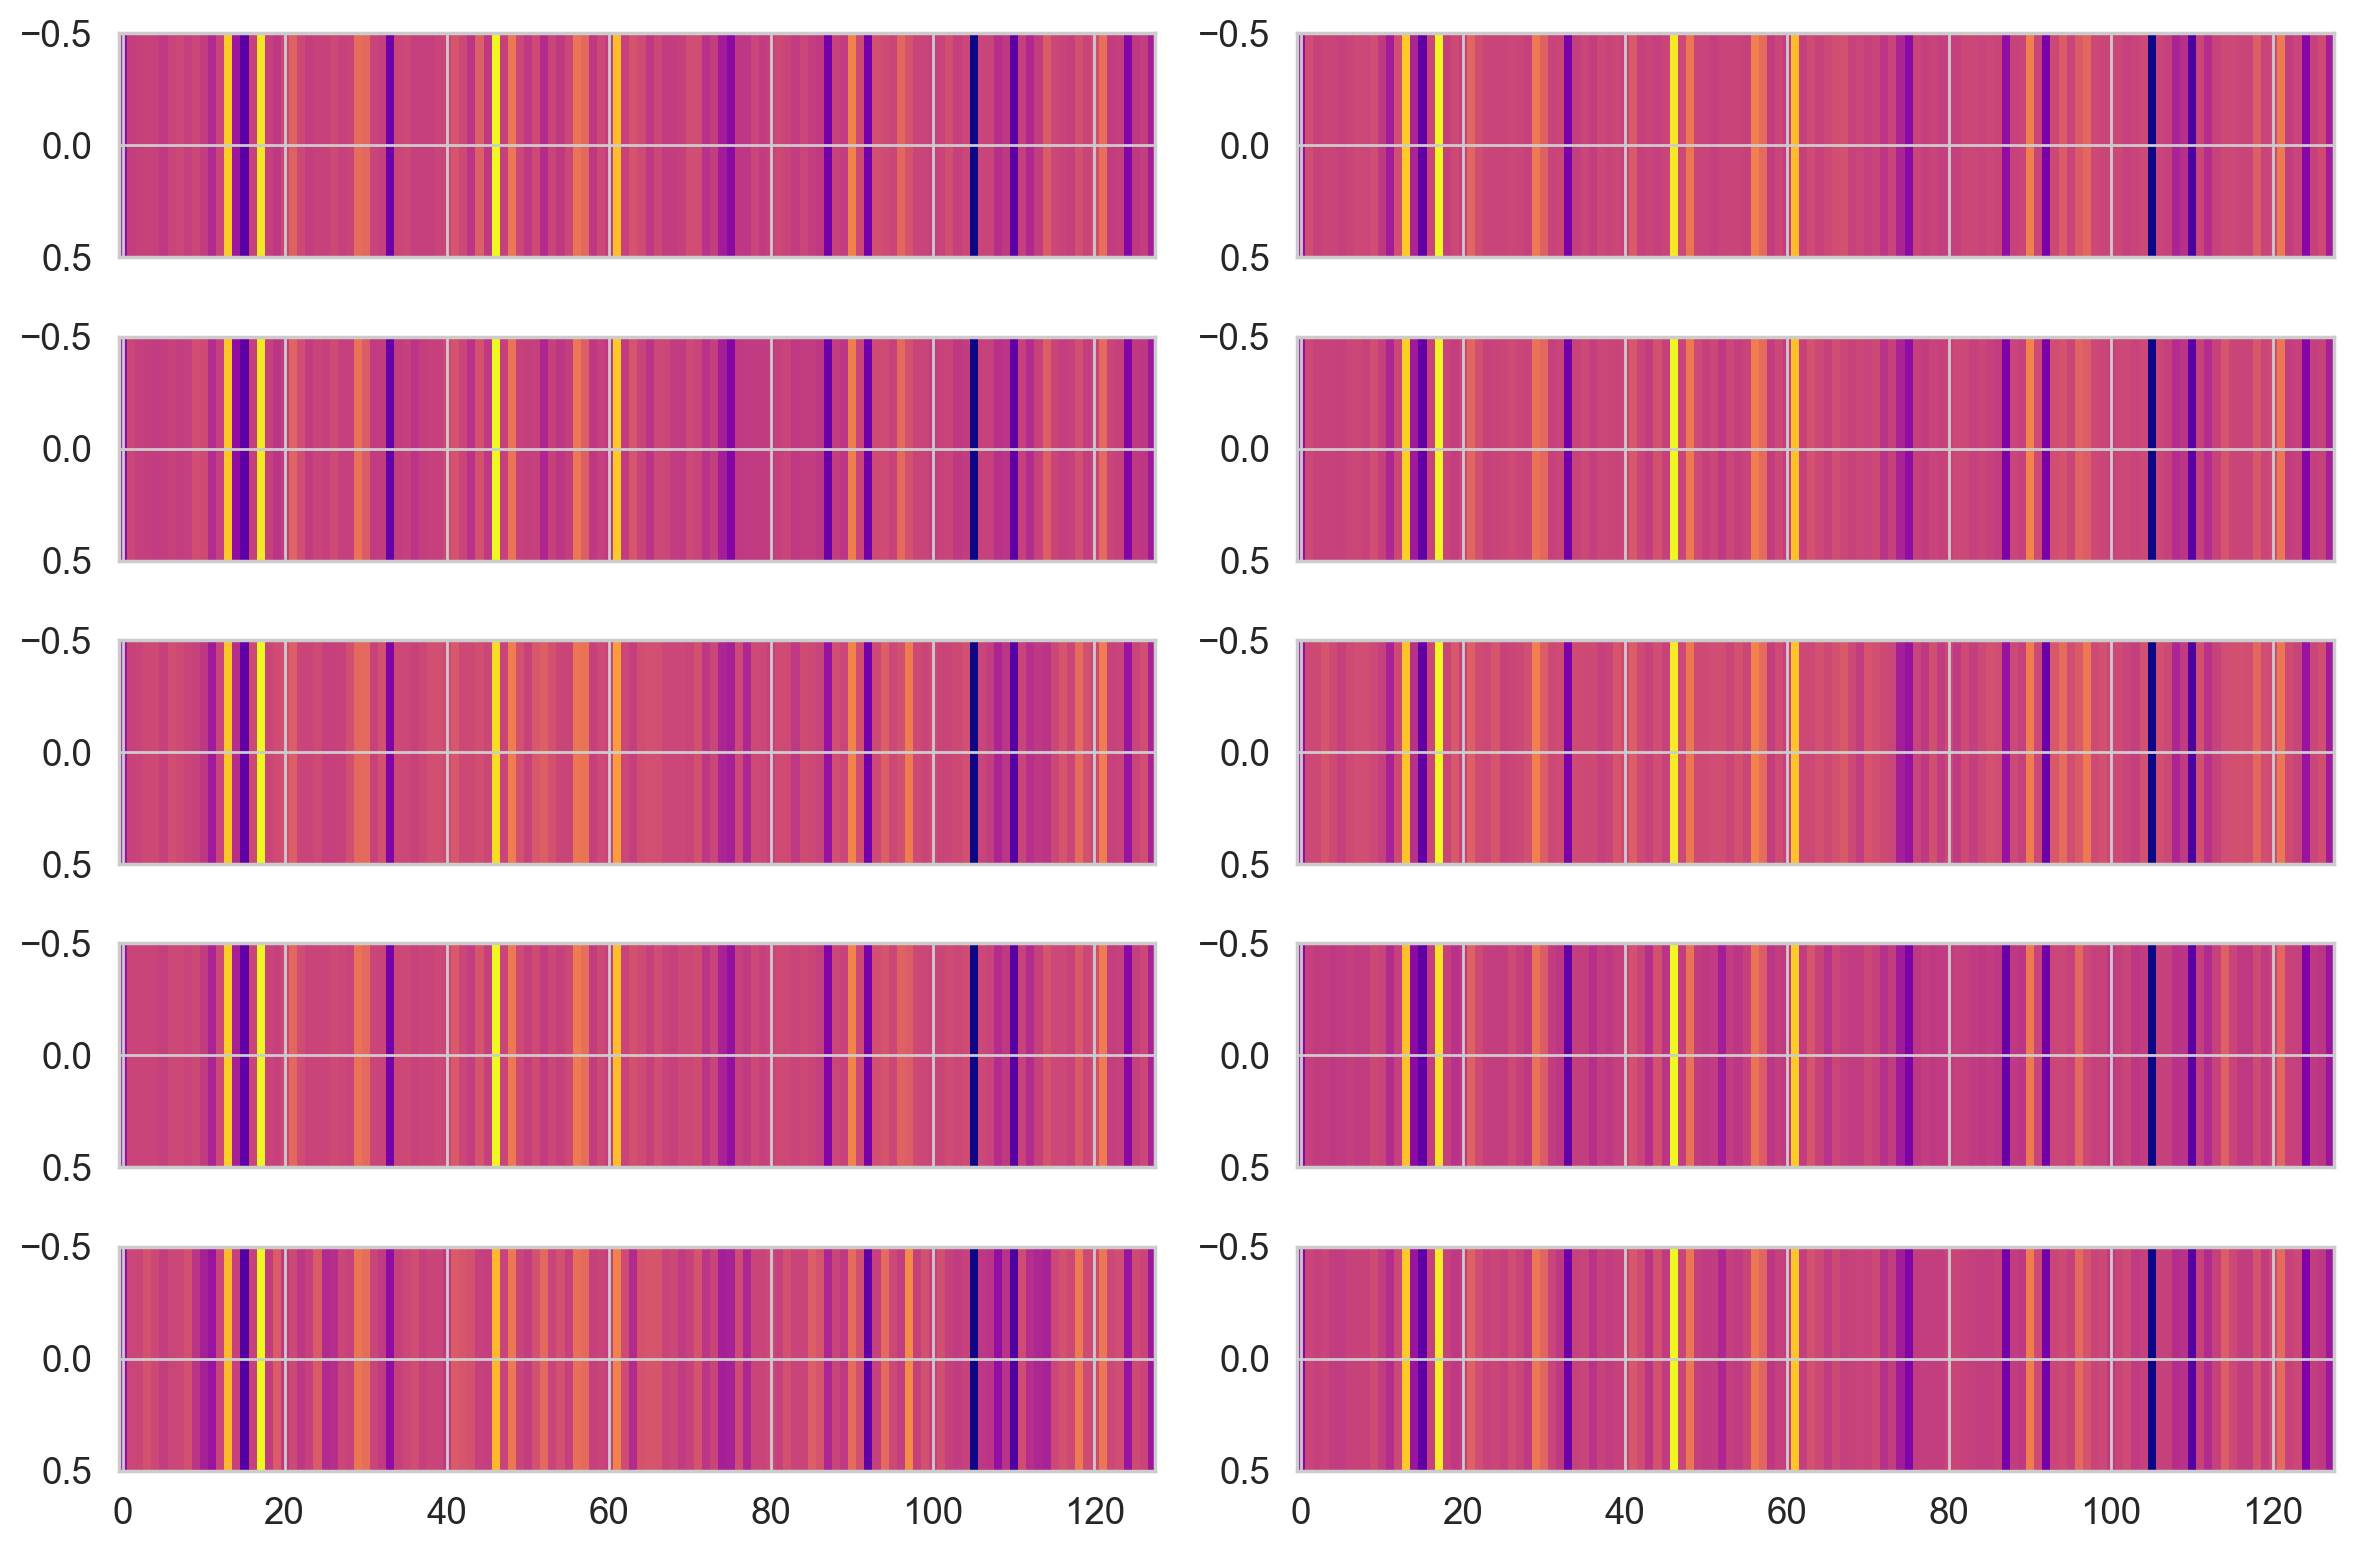

In [ ]:
draw_heatmaps(emb_list[7])

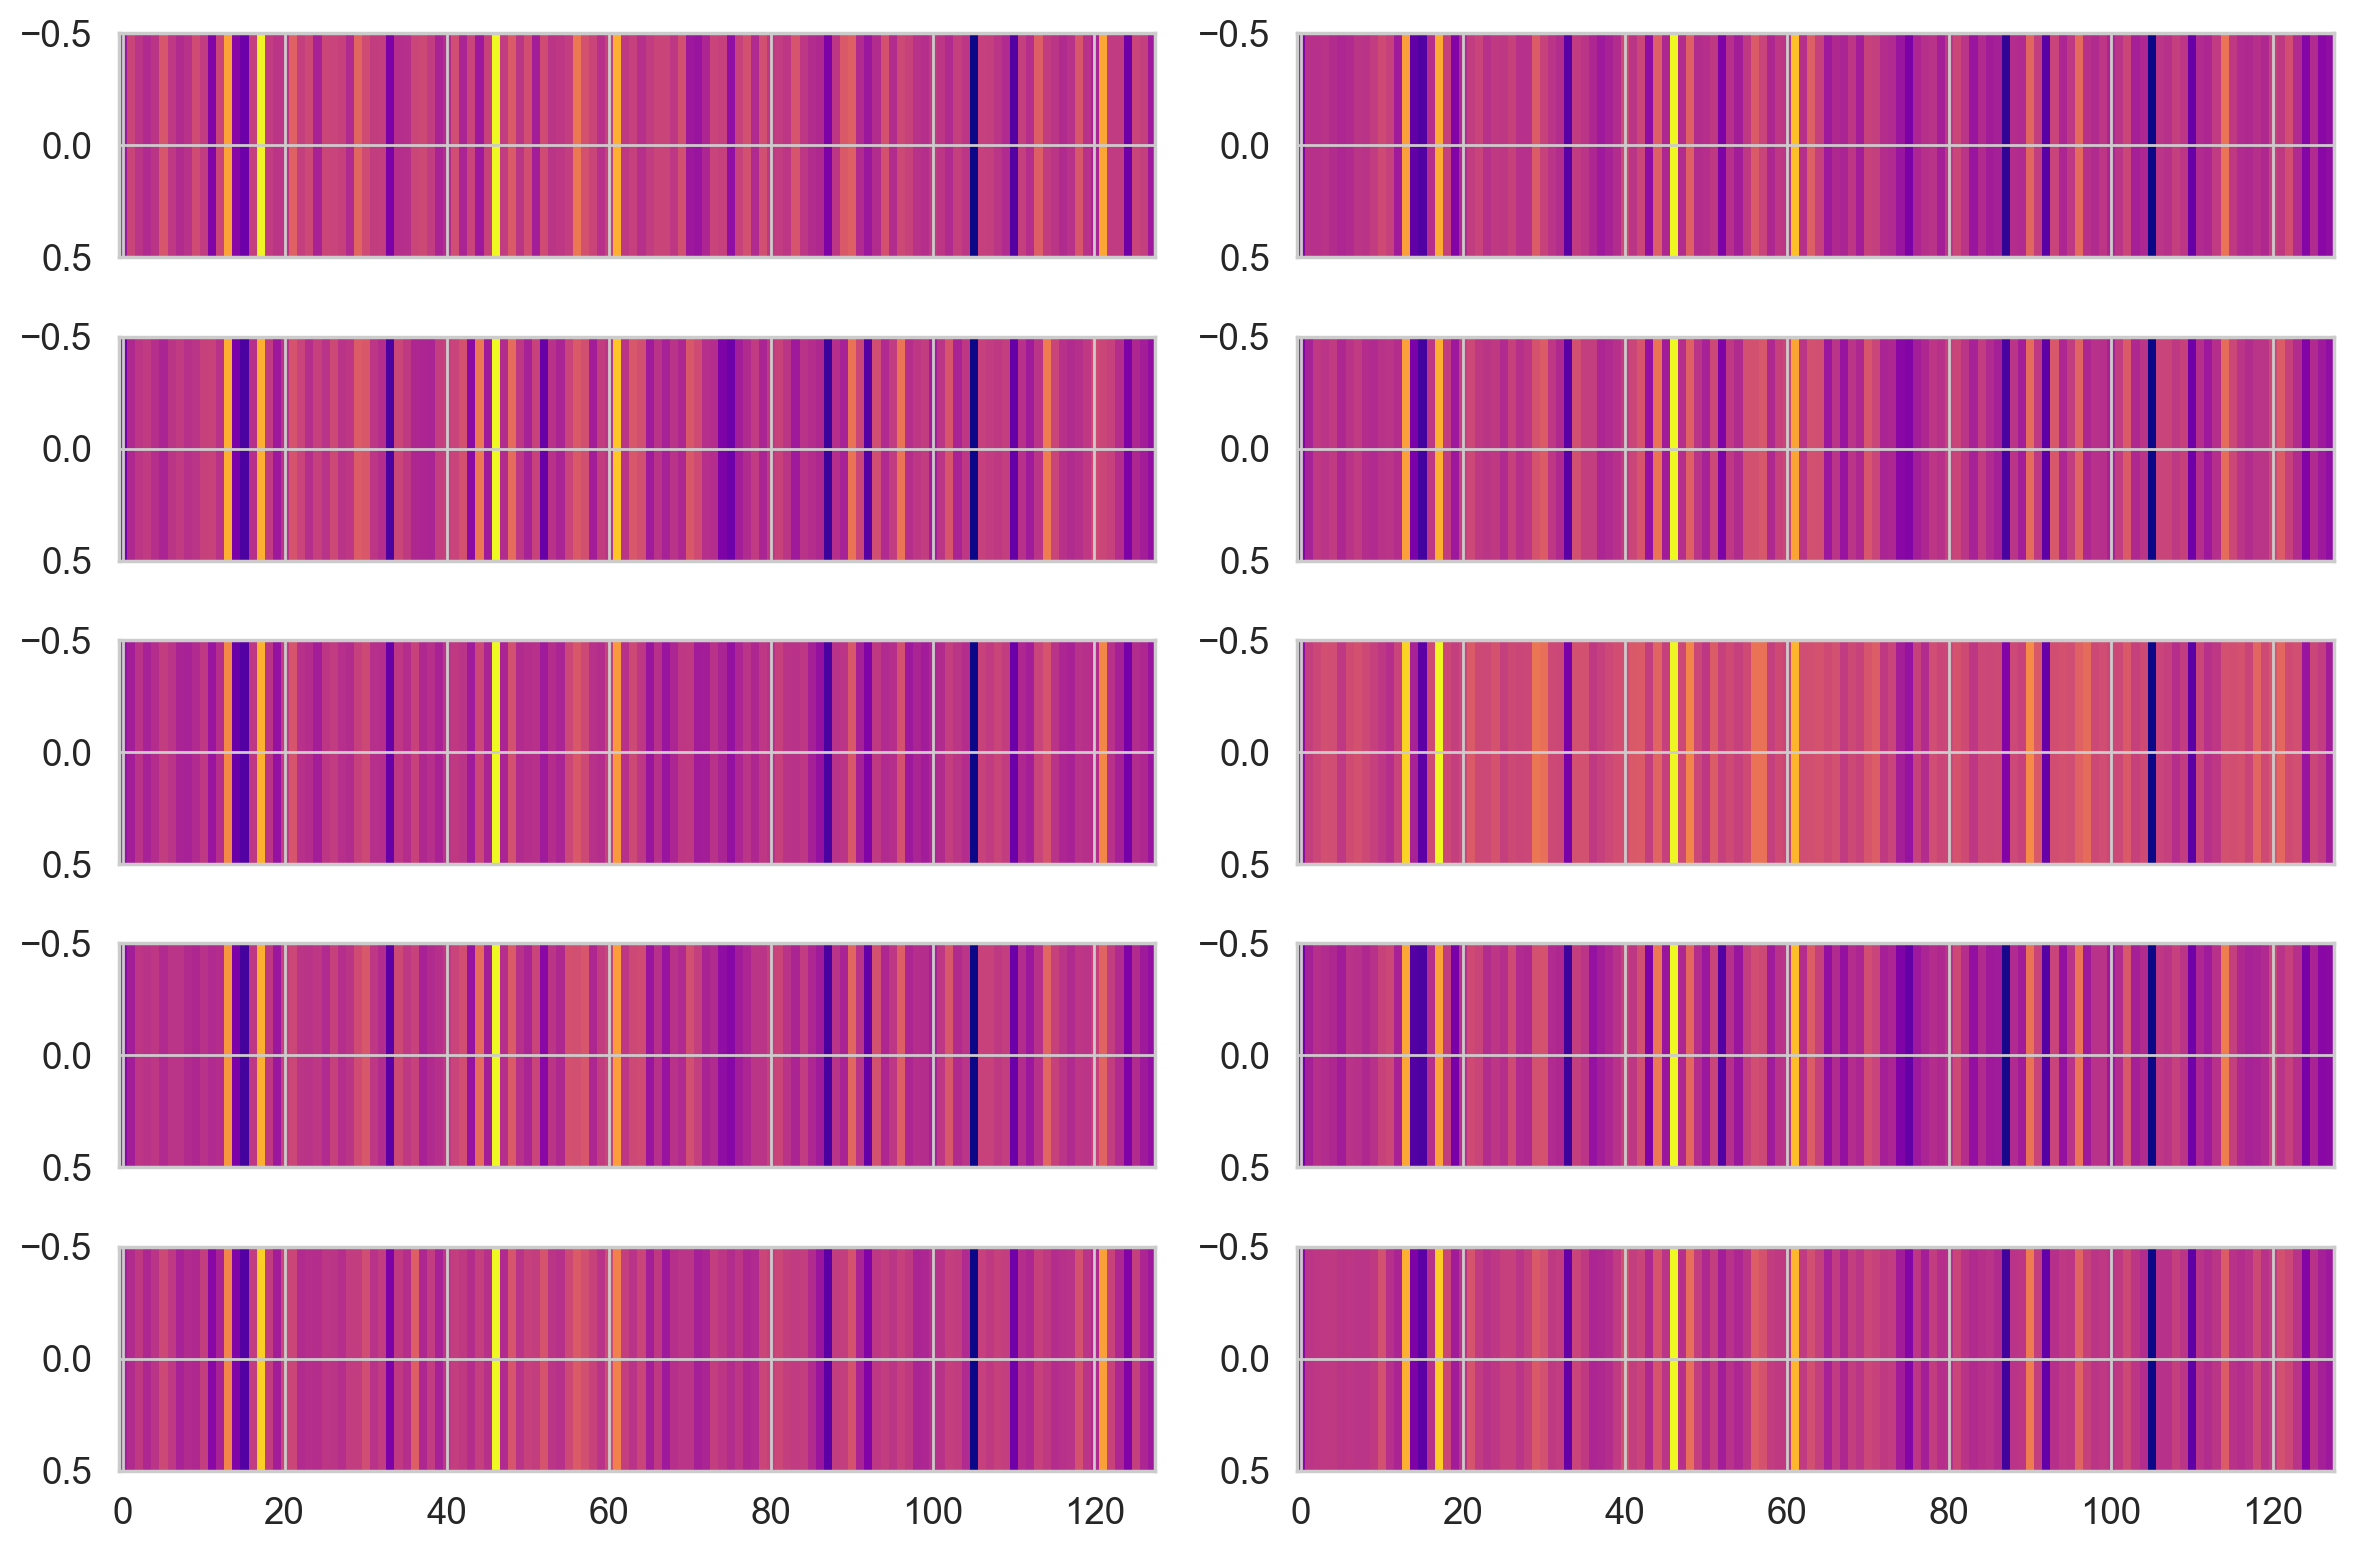

In [ ]:
draw_heatmaps(emb_list[16])

In [ ]:
id2clsname

{0: 'ride_bike',
 1: 'kick',
 2: 'smoke',
 3: 'sword',
 4: 'golf',
 5: 'climb',
 6: 'using_computer',
 7: 'walk',
 8: 'sword_exercise',
 9: 'hit',
 10: 'swing_baseball',
 11: 'brush_hair',
 12: 'ride_horse',
 13: 'dive',
 14: 'shoot_bow',
 15: 'sitting_down',
 16: 'going_up_or_down_stairs',
 17: 'housecleaning',
 18: 'kiss',
 19: 'folding_laundry',
 20: 'ironing',
 21: 'jump',
 22: 'hug',
 23: 'pushup',
 24: 'turn',
 25: 'throw',
 26: 'somersault',
 27: 'push',
 28: 'eat',
 29: 'shake_hands',
 30: 'vacuum_clean',
 31: 'pullup',
 32: 'climb_stairs',
 33: 'cartwheel',
 34: 'fencing',
 35: 'pour',
 36: 'clap',
 37: 'draw_sword',
 38: 'catch',
 39: 'kick_ball',
 40: 'stand',
 41: 'watching_TV',
 42: 'lying_on_floor',
 43: 'wave',
 44: 'chew',
 45: 'run',
 46: 'shoot_gun',
 47: 'situp',
 48: 'handstand',
 49: 'dribble',
 50: 'fall_floor',
 51: 'flic_flac',
 52: 'drink',
 53: 'pick',
 54: 'smile',
 55: 'laugh',
 56: 'talk'}

In [ ]:
test_data = SkeletonDataset(test_file_list,clsname2id,file_name=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [ ]:
def save_video_dataset(model,dataset,model_identifier,unique_identifier):

    with torch.no_grad():
        for __id,(in_seq,tar_seq,action,vid_size,__file_name) in tqdm(enumerate(dataset)):
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,embedding  = model(in_seq)

            for __id,(input_vid,output_vid,action,__fln,vid_s) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0),__file_name,vid_size.unbind(0))):
                __fln = __fln.split('.')[0].split("/")[-1]
                os.makedirs(f"{test_vids}/{model_identifier}/{unique_identifier}/{int(action)}/{__fln}",exist_ok=True)
                # gen_video(input_vid.detach().numpy(),f"{test_vids}/{int(action)}/{__fln}/true.mp4",int(vid_s[0]),int(vid_s[1]))
                # gen_video(output_vid.detach().numpy(),f"{test_vids}/{int(action)}/{__fln}/pred.mp4",int(vid_s[0]),int(vid_s[1]))
                gen_cmp_video(input_vid.detach().numpy(), output_vid.detach().numpy(),f"{test_vids}/{model_identifier}/{unique_identifier}/{int(action)}/{__fln}/cmp.mp4",int(vid_s[0]),int(vid_s[1]))
                
    
    
        
            
        
        #embedding_list[]

In [ ]:
save_video_dataset(model,test_dl,model_ident,unique_iden)

39it [28:44, 44.23s/it]


KeyboardInterrupt: 